In [1]:
# Reds Baseball Analytics Trainee Assessment
# Dew Point and Pitching
# Author: Jameel Kaba

# Import libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Because we're looking at the impact of dew points, we'll use an IsolationForest to detect anomalies (Affected by dew point)
from sklearn.ensemble import IsolationForest

In [2]:
# Load the data
df = pd.read_csv('data.csv')

# Check the data for null values
df.isnull().sum()

PID                             0
INNING_KEY                      0
BATTER_IN_INNING_KEY            0
PITCH_NUMBER                    0
OUT_KEY                         0
BALLS                           0
STRIKES                         0
IS_RUNNER_ON_1B                 0
IS_RUNNER_ON_2B                 0
IS_RUNNER_ON_3B                 0
PITCHER_KEY                     0
THROW_SIDE_KEY                  0
PITCH_TYPE_TRACKED_KEY          0
EVENT_RESULT_KEY             7258
PITCH_RESULT_KEY                0
INDUCED_VERTICAL_BREAK          0
HORIZONTAL_BREAK                0
SPIN_RATE_ABSOLUTE              0
RELEASE_SPEED                   0
RELEASE_SIDE                    0
RELEASE_HEIGHT                  0
RELEASE_EXTENSION               0
HORIZONTAL_APPROACH_ANGLE       0
VERTICAL_APPROACH_ANGLE         0
PLATE_X                         0
PLATE_Z                         0
dtype: int64

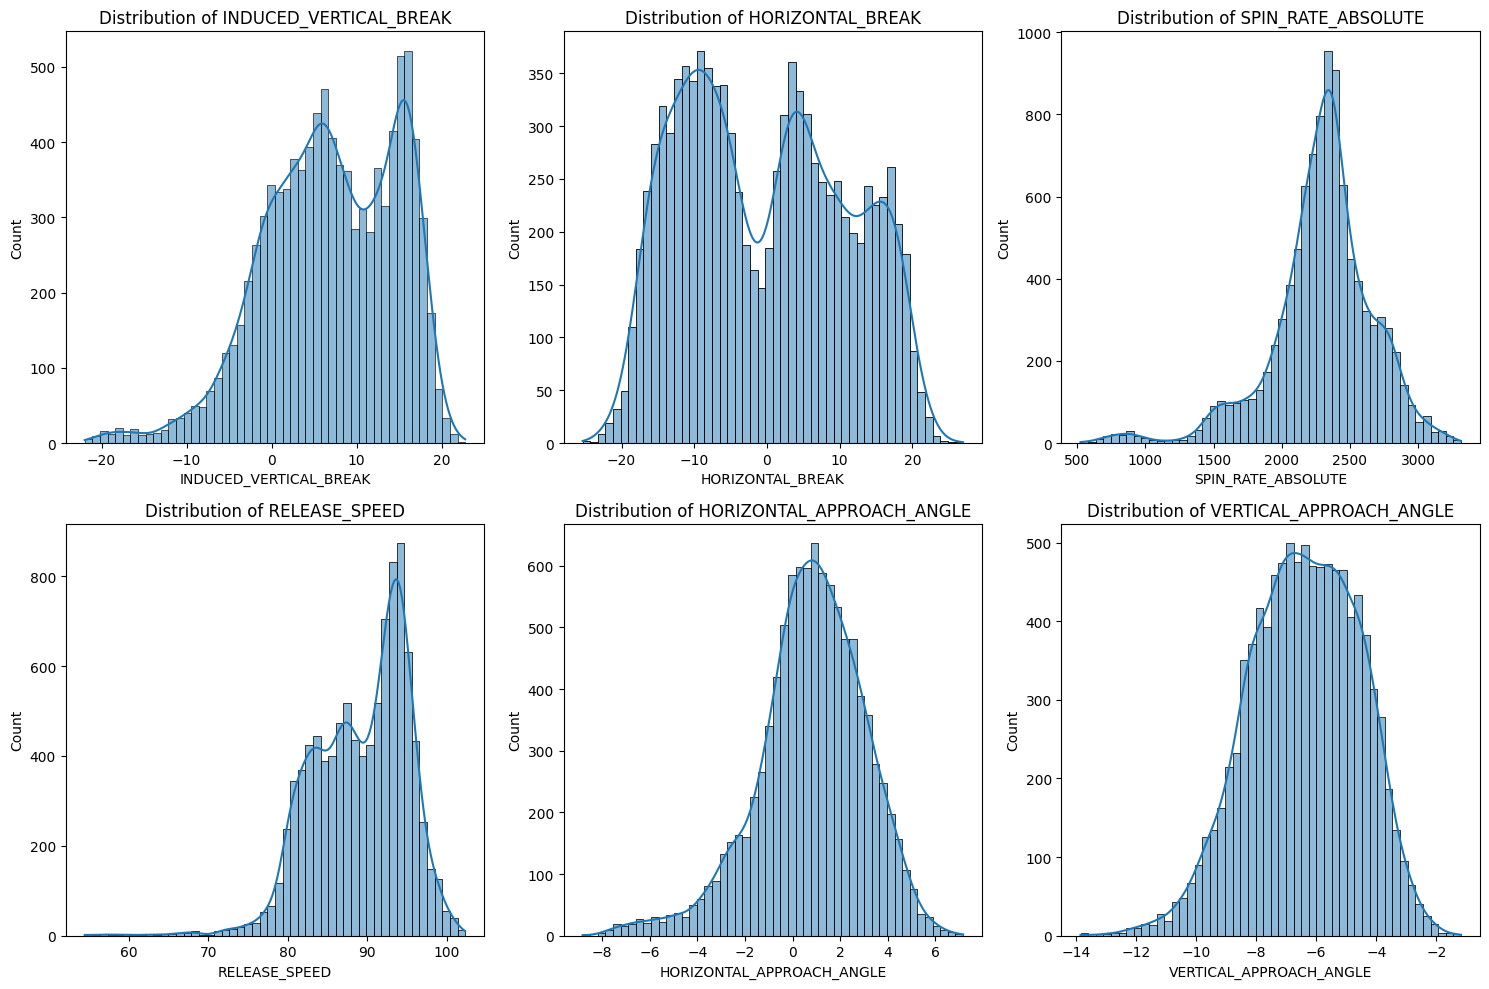

In [3]:
# Visualize the distribution of factors which may be affected by dew point
# Factors to consider involve pitch movement, spin, and speed
pitch_factors = ['INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE', 
                 'RELEASE_SPEED', 'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE']

# Loop to create plots for distribution of factors
plt.figure(figsize = (15, 10))
for i, feature in enumerate(pitch_factors, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], bins = 50, kde = True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

In [4]:
# Let's take a look at the interactions between factors
# To do this, we will add a new column to the dataframe for each interaction

# Interaction between spin and speed
df['spin_speed_interaction'] = df['SPIN_RATE_ABSOLUTE'] * df['RELEASE_SPEED']

# Interaction between spin and vertical break
df['spin_vbreak_interaction'] = df['SPIN_RATE_ABSOLUTE'] * df['INDUCED_VERTICAL_BREAK']

# Interaction between spin and horizontal break
df['spin_hbreak_interaction'] = df['SPIN_RATE_ABSOLUTE'] * df['HORIZONTAL_BREAK']

# Interaction between speed and vertical break
df['speed_vbreak_interaction'] = df['RELEASE_SPEED'] * df['INDUCED_VERTICAL_BREAK']

# Interaction between speed and horizontal break
df['speed_hbreak_interaction'] = df['RELEASE_SPEED'] * df['HORIZONTAL_BREAK']

# Let's take a look at the first few rows of these interactions 
df[['spin_speed_interaction', 'spin_vbreak_interaction', 'spin_hbreak_interaction', 
      'speed_vbreak_interaction', 'speed_hbreak_interaction']].head()

,spin_speed_interaction,spin_vbreak_interaction,spin_hbreak_interaction,speed_vbreak_interaction,speed_hbreak_interaction
0,242083.876498,34937.053457,-29695.126009,1465.344783,-1245.485628
1,228325.856782,32405.444483,-24895.069103,1431.523424,-1099.749598
2,207951.910770,12888.695039,10075.654647,500.348404,391.144154
3,210199.042552,11246.869486,9999.709018,431.578655,383.721085
4,217681.142997,10105.594342,3971.867060,367.842205,144.575399


In [5]:
# Factors we are going to use in our Isolation Forest 
forest_factors = ['INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE', 'RELEASE_SPEED', 
                  'spin_speed_interaction', 'spin_vbreak_interaction', 'spin_hbreak_interaction', 
                  'speed_vbreak_interaction', 'speed_hbreak_interaction']

# Initialize the Isolation Forest
forest = IsolationForest(contamination = 0.1, random_state = 100)

# Fit the model
forest.fit(df[forest_factors])

# Predict anomaly scores (higher scores indicate higher probability of being an anomaly)
anomaly_scores = forest.decision_function(df[forest_factors])

# Use our model to predict anomalies, -1 refers to an anomaly, 1 refers to normal
df['anomaly'] = forest.predict(df[forest_factors])

# Convert anomaly scores to probabilities (higher values indicate higher probability of being affected by dew point)
df['probabilities'] = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

# Let's take a peek at the probabilities
df['probabilities'][:10]

0    0.731436
1    0.818433
2    0.956218
3    0.972980
4    0.952894
5    0.556197
6    0.538532
7    0.958016
8    0.593807
9    0.711689
Name: probabilities, dtype: float64

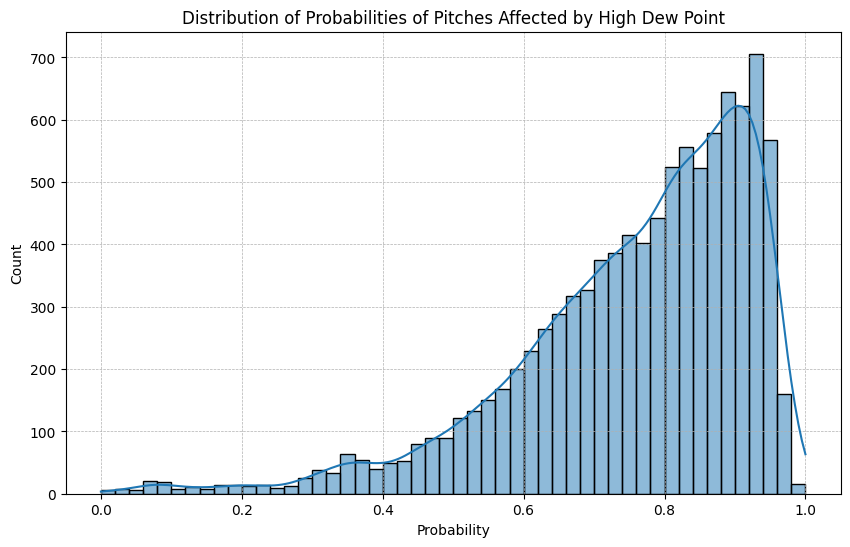

In [6]:
# Visualizing the distribution of probabilities
plt.figure(figsize=(10, 6))
sns.histplot(df['probabilities'], bins=50, kde = True)
plt.title('Distribution of Probabilities of Pitches Affected by High Dew Point')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

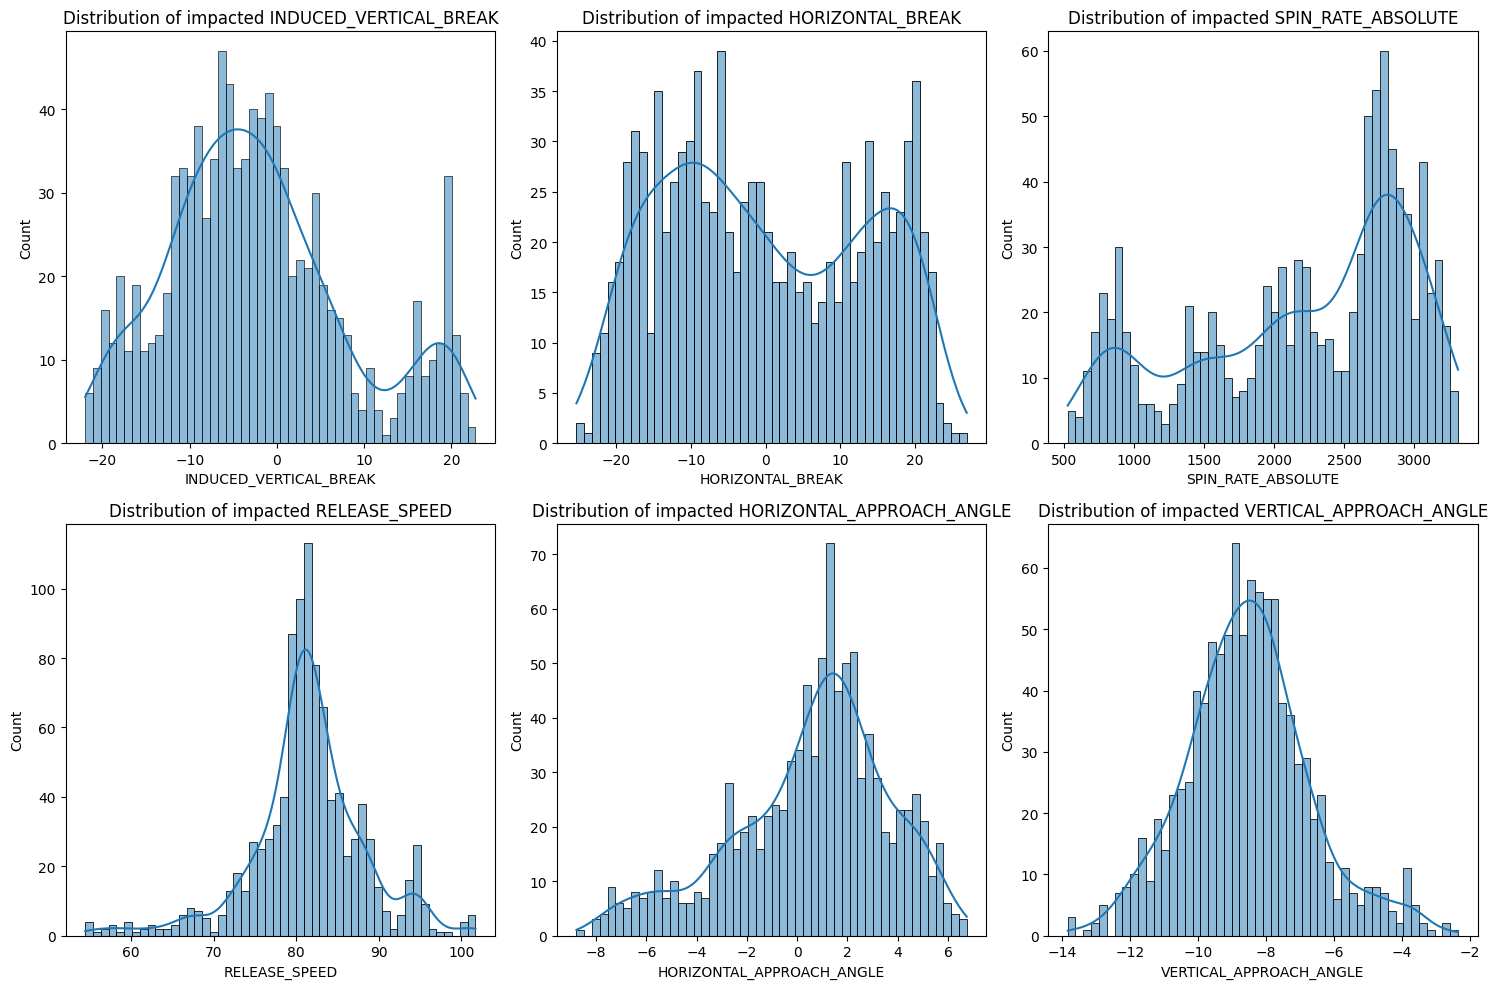

In [7]:
# Let's look at how factors are impacted, for pitches that have been classified as anomalies.

# Filter dataset so we get the pitches classified as anomalies ("Affected by high dew point")
rslt_df = df[df['anomaly'] == -1] 

# Setup plot, and loop through to create plots
plt.figure(figsize = (15, 10))
for i, feature in enumerate(pitch_factors, 1):
    plt.subplot(2, 3, i)
    sns.histplot(rslt_df[feature], bins = 50, kde = True)
    plt.title(f'Distribution of impacted {feature}')
    plt.tight_layout()

In [8]:
# Round probabilities to 2 decimal points
df['probabilities'] = df['probabilities'].apply(lambda x: round(x, 2))

# Prepare the submission DataFrame, we need PID and the probabilities the pitch was affected
submission_df = pd.DataFrame({'PID': df['PID'], 'DEWPOINT_AFFECTED': df['probabilities']})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_JK.csv', index=False)